In [1]:
%matplotlib inline

import os
import sys
import timeit
import urllib
import gzip
import pickle
from functools import reduce

import tensorflow as tf

import PIL
from scipy.ndimage import imread

import blosc
import dill

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import Ridge
import pandas as pd
sys.path.append(os.path.abspath('..\\..\\..\\dataset'))

import dataset as ds
from dataset.opensets import MNIST
from dataset import FilesIndex, Dataset
from dataset import B, V, C, F
from dataset import action
from dataset.models.tf import VGG7, VGG16, VGG19
from dataset.models.tf import VNet
from dataset.models.tf import UNet
from dataset.models.tf import SqueezeNet
from dataset.models.tf import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from dataset.models.tf import MobileNet
from dataset.models.tf import LinkNet
from dataset.models.tf import Inception_v1, Inception_v3, Inception_v4
from dataset.models.tf import FCN8, FCN16, FCN32
from dataset.models.tf import DenseNet121, DenseNet169, DenseNet201, DenseNet264
from dataset import Pipeline

# from MNISTBatch import AugmentedMNISTBatch

import seaborn as sns

In [2]:
def show_img(axis, image, title, grey=False):
    if grey:
        axis.imshow(image, cmap=plt.get_cmap('Greys'))
    else:
        axis.imshow(image)
    axis.set_title(title, fontsize=12)
    axis.tick_params(bottom='off', labelbottom='off', left='off', labelleft='off')

In [3]:
def get_image_jpeg(file_name):
    img = imread(file_name)
    return img
    


In [4]:
def dump_image_blosc(data, file_name):
    with open(file_name + '.blosc', 'w+b') as f:
        f.write(blosc.compress(dill.dumps(data)))
        
        
def get_image_blosc(file_name):
    with open(file_name, 'rb') as f:
        img = dill.loads(blosc.decompress(f.read()))
    return img


def compress_images(folder_from, folder_to):
    os.makedirs(folder_to, exist_ok=True)
    images_files = os.listdir(folder_from)
    for imfile in tqdm(images_files):
        impath = os.path.join(folder_from, imfile)
        if not os.path.isdir(impath):
            image = plt.imread(impath)
            dump_image_blosc(image, os.path.join(folder_to, imfile[:-4]))
# compress_images('D:/images/', 'D:/blosc_images')

In [5]:
"""Batch class for water meter task"""
import sys
import re

from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('..')
from dataset import ImagesBatch, action, inbatch_parallel

class WaterBatch(ImagesBatch):
    """Class to create batch with water meter"""
    components = 'images', 'labels', 'coordinates', 'indices'
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._time_stamps = {}
        
    @action
    def record_time(self, stat_name='statistics', mode='record'):
        """
        Make a time stamp or record the difference between the previous
        one for a specified list in the pipeline

        Parameters
        ----------
        stat_name : str
                    name of the statistics in the pipeline for which the operation is conducted
        mode : {'record', 'diff'}
               if 'record' is given then the current time is recorded with the handler specified by `stat_name`
               if 'diff' is given then the difference between the current time and the last recorded time for
               the given handler (`stat_name`) is appended to `stat_name` in the pipeline

        Returns
        -------
        self : MNISTBatchTime

        """
        if mode == 'record':
            
            self._time_stamps[stat_name] = time()
#             if stat_name == 'resize_time':
#             print(stat_name, self._time_stamps)
        elif mode == 'diff':
#             if stat_name == 'resize_time':
            print(stat_name, time()-self._time_stamps[stat_name])
            self.pipeline.update_variable(
                stat_name,
                time()-self._time_stamps[stat_name],
                mode='append')
#             if stat_name == 'resize_time':
#                 print('array',self.pipeline.get_variable(stat_name))
        return self

    @inbatch_parallel('indices', post='assemble')
    def _load_jpg(self, ind, src, components=None):
        _ = components, self
        images  = get_image_blosc(os.path.join(src, 'blosc_images', ind + '.blosc'))
#         images = plt.imread(src + ind + '.jpg').astype(np.float32)
        return images

    def _load_csv(self, src, components=None, *args, **kwargs):
        if src[-4:] != '.csv':
            src += '.csv'
        _data = pd.read_csv(src, *args, **kwargs)
        if 'file_name' in _data.columns:
            _data.set_index('file_name', inplace=True)
            _data = _data.loc[self.indices].counter_value.values
        else:
#             print(self.indices)
            indices = [int(ind[1:3]) for ind in self.indices]
            coord = []

            for ind in indices:
                string = _data.loc[ind].values[0][36:-7]
                coord.append(list([int(i) for i in re.sub('\\D+', ' ', string).split(' ')[1:]]))
            _data = np.array(coord).astype(np.float32)
        setattr(self, components, _data)

    @action
    def load(self, src, fmt=None, components=None, *args, **kwargs):
        """
        Parameters
        ----------
        src :
            a source (e.g. an array or a file name)
        fmt : str
            a source format, one of 'jpg' or 'csv'
        components : None or str or tuple of str
            components to load
        *args :
            other parameters are passed to format-specific loaders
        **kwargs :
            other parameters are passed to format-specific loaders
        """
        if fmt == 'jpg':
            self._load_jpg(src, components)
        elif fmt == 'csv':
            self._load_csv(src, components, *args, **kwargs)
        else:
            raise ValueError("Unknown format " + fmt)
        return self
    
    
    @action
    @inbatch_parallel(init='indices')
    def normalize_all(self, ix, factor):
        image = self.get(ix, 'images').astype(np.float32)
        image[image <= 0] = 0
        self[ix].images = image / 255.
        
        coords = self[ix].coordinates.astype(np.float32)
        coords[0] /= image.shape[1]
        coords[2] /= image.shape[1]
        coords[1] /= image.shape[0]
        coords[3] /= image.shape[0]
        self[ix].coordinates = coords
        
        
    @action
    @inbatch_parallel(init='indices', post='assemble')
    def shift_bb(self, ix,p, shift, **kwargs):
        image = self.get(ix, 'images').astype(np.float32)
        shift, p = self.convert_args_type(shift, p)
        if np.random.random() < p():
            shift = shift()
#             print()
            image = self._shift_image(image, shift=shift, **kwargs)
            coords = self[ix].coordinates.astype(np.float32)
            coords[0] += shift[1]
            coords[1] += shift[0]
            self[ix].coordinates = coords
        return image
    
    
    @action
    @inbatch_parallel(init='indices', post='assemble')
    def resize_bb(self, ix, shape):
        image = self.get(ix, 'images').astype(np.float32)
        imshape = np.asarray(image.shape[:-1]).astype(np.float32)
        factor = np.asarray(shape)/imshape
        
        coords = self[ix].coordinates.astype(np.float32)
        coords[0] *= factor[1]
        coords[2] *= factor[1]
        coords[1] *= factor[0]
        coords[3] *= factor[0]
        self[ix].coordinates = coords
        
        return self._resize_image(image, shape)
    
    
    @action
    @inbatch_parallel(init='indices', post='assemble')
    def scale_bb(self, ix, components='images', factor=None, preserve_shape=True, origin='center', p=1.):
        factor, preserve_shape, origin, p = self.convert_args_type(factor, preserve_shape, origin, p)
        image = self.get(ix, 'images')
        if np.random.random() < p():
            factor = factor()
            coords = self[ix].coordinates.astype(np.float32)
            coords[0] *= factor[1]
            coords[2] *= factor[1]
            coords[1] *= factor[0]
            coords[3] *= factor[0]
            self[ix].coordinates = coords
            if np.any(np.asarray(factor) <= 0):
                raise ValueError("factor must be greater than 0")
            image_shape = self.get_image_shape(image)
            rescaled_shape = np.ceil(np.array(image_shape) * factor).astype(np.int16)
            rescaled_image = self._resize_image(image, rescaled_shape)
            if preserve_shape():
                origin = origin()
                if isinstance(origin, str) and origin not in ['top_left', 'center', 'random']:
                    raise ValueError('str value of origin must be one of [\'top_left\', \'center\', \'random\']')
                if isinstance(origin, str) and origin == 'random':
                    origin = (np.random.randint(image.shape[0]-rescaled_image.shape[0]+1),
                              np.random.randint(image.shape[1]-rescaled_image.shape[1]+1))
                rescaled_image = self._preserve_shape(image, rescaled_image, origin)
            return rescaled_image
        return image

In [6]:
src = 'C:/Users/Gregory Ivanov/Desktop/learn/'


In [7]:
dset = Dataset(index=FilesIndex(path='C:/Users/Gregory Ivanov/Desktop/learn/blosc_images/*.blosc', no_ext=True),
               batch_class=WaterBatch)
dset.cv_split(0.9)
batch_size = 32
epoch_size=len(dset.train) // batch_size

In [8]:
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

In [15]:
b_block = dict(post_activation=None, downsample=False,
                                       bottleneck=True, bottleneck_factor=4,
                                       width_factor=1,
                                       resnext=False, resnext_factor=32,
                                       se_block=False, se_factor=16,layout = 'nacancanc')

In [ ]:
def smooth_l1(labels, predictions, **kwargs):
    mu = 0.001
    if labels is None:
        raise ValueError("labels must not be None.")
    if predictions is None:
        raise ValueError("predictions must not be None.")
    with ops.name_scope(scope, "smooth_l1",
                       (predictions, labels, weights)) as scope:
        predictions = math_ops.to_float(predictions)
        labels = math_ops.to_float(labels)
        predictions.get_shape().assert_is_compatible_with(labels.get_shape())
#         losses = math_ops.squared_difference(predictions, labels)
        
        
        return compute_weighted_loss(losses, weights, scope, loss_collection, reduction=reduction)

In [48]:
shift_generator = lambda : np.append(np.random.normal([15, 10],[5, 10]), 0)
factor_generator=lambda : np.minimum(1.5, np.maximum(0.5, np.random.normal(1, 0.1, 2)))
factor=(896, 1600)
pipeline = (Pipeline()
         .init_variable('model_arch', ResNet50)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('load_time', init_on_each_run=list)
         .init_variable('resize_time', init_on_each_run=list)
         .init_variable('train_time', init_on_each_run=list)
         .init_variable('predictions', init_on_each_run=0)
         .init_model('dynamic', V('model_arch'), 'model',
                     config={'body/block' : b_block,
                             'session' : {'config' : session_config},
                             'inputs' : {'images': {'shape': B('image_shape'),
                                                    'data_format': 'channels_last'},
                                         'labels': {'name': 'targets', 'shape' : (4,)}},
#                              'loss' : {'name' : 'huber', 'delta' : 1.},
                             "loss" : {'name' : tf.losses.absolute_difference},
                             'decay': {'name': 'invtime',
                                       'decay_steps' : epoch_size*20,
                                       'decay_rate': .7,
                                       'learning_rate' : 0.01},
                             'optimizer': ('GradientDescent'),
                             'input_block/inputs' : 'images'})
#          .record_time(stat_name='load_time', mode='record')
         .load(src=src, fmt='jpg', components='images')
         .load(src=src+'labels/meters.csv', \
              fmt='csv',\
              components='labels',\
              usecols=['file_name', 'counter_value'])
         .load(src=src+'labels/answers.csv', \
              fmt='csv', \
              components='coordinates',\
              usecols=['markup'])
#          .record_time(stat_name='load_time', mode='diff')
#          .record_time(stat_name='resize_time', mode='record')
         .resize_bb(shape=(112, 200))
         .invert(p=(.1,.1,.1))
         .scale_bb(factor=factor_generator, preserve_shape=True, origin='top_left', p=.7)
         .shift_bb(p=.7, shift=shift_generator, order=0, mode='nearest')
         .salt_and_pepper(mode=0.5, p=.03)
         .normalize_all(factor=factor)
#          .record_time(stat_name='resize_time', mode='diff')
#          .record_time(stat_name='train_time', mode='record')
         .train_model('model', fetches=['loss', 'predictions'],
                      feed_dict={'images': B('images'),
                                 'labels': B('coordinates')},
                      save_to=[V('current_loss'), V('predictions')], use_lock=True))
#          .record_time(stat_name='train_time', mode='diff'))

def get_pipeline(template_pipeline, dataset, pipeline_variables={}, model_config={}):
    pipeline = template_pipeline << dataset    
    for variable, value in pipeline_variables.items():
        pipeline.set_variable(variable, value)
    pipeline.set_config(model_config)
    return pipeline


In [49]:
train_pipeline = get_pipeline(pipeline, dset.train)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


block
{'batch_norm': {'momentum': 0.1}, 'num_blocks': [3, 4, 6, 3], 'is_training': <tf.Tensor 'ResNet50/globals/is_training:0' shape=<unknown> dtype=bool>, 'data_format': 'channels_last', 'post_activation': None, 'downsample': False, 'bottleneck': True, 'bottleneck_factor': 4, 'width_factor': 1, 'resnext': False, 'resnext_factor': 32, 'se_block': False, 'se_factor': 16, 'layout': 'nacancanc'}
kwargs
{'batch_norm': {'momentum': 0.1}, 'num_blocks': [3, 4, 6, 3], 'is_training': <tf.Tensor 'ResNet50/globals/is_training:0' shape=<unknown> dtype=bool>, 'data_format': 'channels_last'}
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc
bottleneck: nacancanc


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



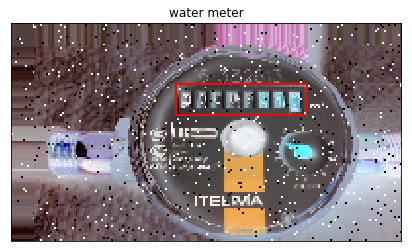

In [50]:
def add_bb(img, bb):
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    
    img[min(im_height,lr), min(im_width,lc):min(im_width,lc+w),:]=[1,0,0]
    img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc),:]=[1,0,0]
    img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w),:]=[1,0,0]
    img[min(im_height,lr+h), min(im_width,lc):min(im_width,lc+w),:]=[1,0,0]


f,a=plt.subplots(1,1, figsize=(7,7))
# 
b = train_pipeline.next_batch(1, shuffle=True, n_epochs=None, drop_last=False)
# bb_predicted = train_pipeline.get_variable('predictions')[0]
img = b.images[0]
img[img <= 0] = 0
bb = b.coordinates[0]
bb[[0,2]] *= img.shape[1]
bb[[1,3]] *= img.shape[0]
add_bb(img, bb)
show_img(a, img, 'water meter', False)

# bb = bb.astype(np.int)
# img = img[bb[1]:bb[1]+bb[3], bb[0]:bb[0]+bb[2]]

# show_img(a[1], img, 'water meter', False)

In [ ]:
value = 0
epoch_size=len(dset.train) // batch_size
# print(epoch_size)
# train_pipeline = get_pipeline(pipeline, dset.train)
for i, b in tqdm(enumerate(train_pipeline.gen_batch(batch_size,
                                                    shuffle=True,
                                                    n_epochs=150,
                                                    drop_last=False,
                                                    prefetch=8))):
    value += 0.8 * train_pipeline.get_variable('current_loss')
    if (i+1) % epoch_size==0:
        print('epoch', int((i+1)/epoch_size), 'loss', value/epoch_size, 'sqrt loss', np.sqrt(value/epoch_size))
        value=0

A Jupyter Widget

C:\ProgramData\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [59]:

factor=(896, 1600)
tpipeline = (Pipeline()
         .import_model('model', train_pipeline)
         .init_variable('predictions', init_on_each_run=0)
         .init_variable('last_batch_images', init_on_each_run=0)
         .load(src=src, fmt='jpg', components='images')
         .load(src=src+'labels/meters.csv', \
              fmt='csv',\
              components='labels',\
              usecols=['file_name', 'counter_value'])
         .load(src=src+'labels/answers.csv', \
              fmt='csv', \
              components='coordinates',\
              usecols=['markup'])
         .update_variable('last_batch_images', B('images'))
         .resize_bb(shape=(112, 200))
#          .shift_bb(p=1., shift=shift_generator, order=0)
         .normalize_all(factor=factor)
         .predict_model('model', fetches='predictions',
                      feed_dict={'images': B('images'),
                                 'labels': B('coordinates')},
                      save_to=V('predictions')))

test_pipeline = get_pipeline(tpipeline, dset.test)

In [60]:
bb

array([ 84.42643738,  31.9785881 ,  67.07652283,  16.14683342], dtype=float32)

[ 69.74821472  37.90135956  53.69244385  10.56438541]


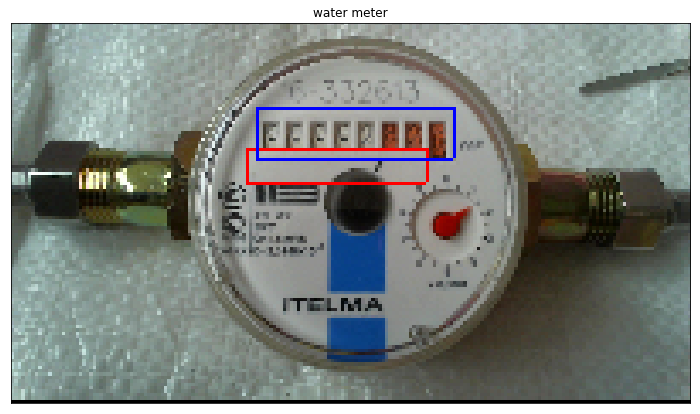

In [80]:
f,a=plt.subplots(1,1, figsize=(16,7))

def add_bb(img, bb, c):
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    for i in range(2):
        img[min(im_height,lr):min(im_height,lr)+i, min(im_width,lc):min(im_width,lc+w),:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc):min(im_width,lc)+i,:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w):min(im_width,lc+w)+i,:]=c
        img[min(im_height,lr+h):min(im_height,lr+h)+i, min(im_width,lc):min(im_width,lc+w),:]=c

    return img

for ai in [a]: 
    b = test_pipeline.next_batch(1, shuffle=True, n_epochs=None, drop_last=False)
    bb_predicted = test_pipeline.get_variable('predictions')[0]
#     bb_predicted = test_pipeline.get_variable('predictions')[0]
    bb_real = b.coordinates[0]
#     img = test_pipeline.get_variable('last_batch_images')[0]/255.

    img=b.images[0]
#     print(type(img))
    img[img <= 0] = 0
    # bb = b.coordinates[0]
    bb_predicted[[0,2]] *= img.shape[1]
    bb_predicted[[1,3]] *= img.shape[0]
    print(bb_predicted)
    bb_real[[0,2]] *= img.shape[1]
    bb_real[[1,3]] *= img.shape[0]

    img=add_bb(img, bb_predicted, [1,0,0])
    img=add_bb(img, bb_real, [0,0,1])
    show_img(ai, img, 'water meter', False)

In [126]:
len(dset.test)

540

ValueError: setting an array element with a sequence.

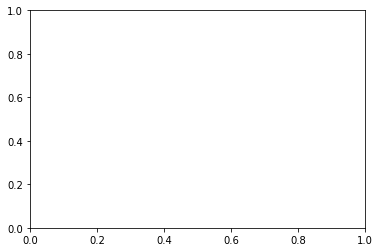

In [37]:


f, a = plt.subplots(1,1)

b = test_pipeline.next_batch(1)
img = b.images[0]
bb = np.asarray(test_pipeline.get_variable('prediction') * 28).astype(np.uint8)
add_bb(img, bb)
show_img(a, img.squeeze(), 'kek', True)